<a href="https://colab.research.google.com/github/flaviorv/pb_ai_ml/blob/main/Copy_of_pb_tp5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Topics: 2
Topic 0: love man know say play come way scene thing year - docs: 20235
Topic 1: scene look actor plot acting say know work director play - docs: 19765

Topics: 3
Topic 0: man love know say come way thing end want woman - docs: 13222
Topic 1: plot look scene acting say horror actor waste thing know - docs: 13447
Topic 2: play love performance role actor series scene cast star comedy - docs: 13331

Topics: 5
Topic 0: man love woman young family year war play world scene - docs: 8870
Topic 1: horror plot acting look scene effect budget actor waste script - docs: 8691
Topic 2: play performance love role scene actor music cast excellent song - docs: 4368
Topic 3: say funny know thing laugh want kid look scene end - docs: 9412
Topic 4: series episode tv comedy original funny black new say star - docs: 8659

Topics: 10
Topic 0: world love live way know feel say human real come - docs: 3176
Topic 1: hour plot half scene minute say boring end review thing - docs: 4355
Topic 2: fun e

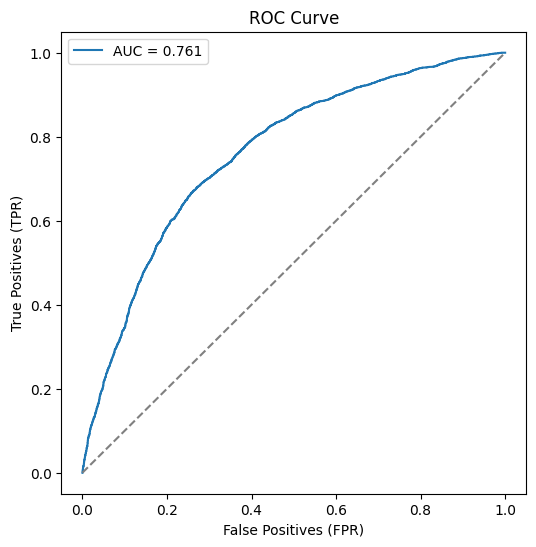

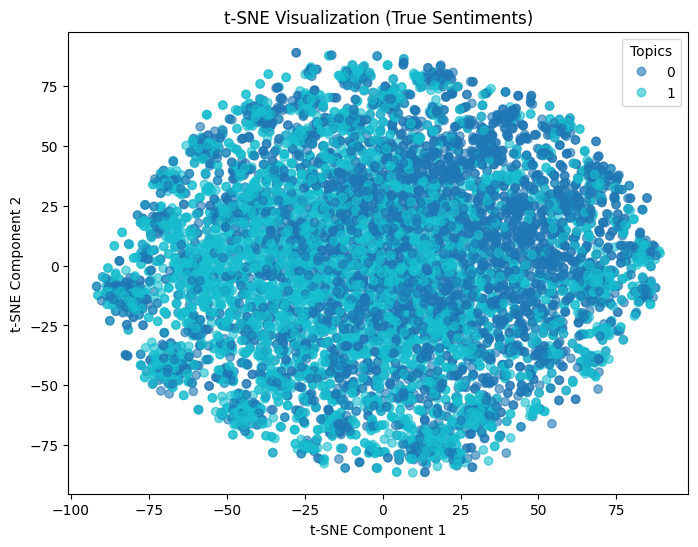

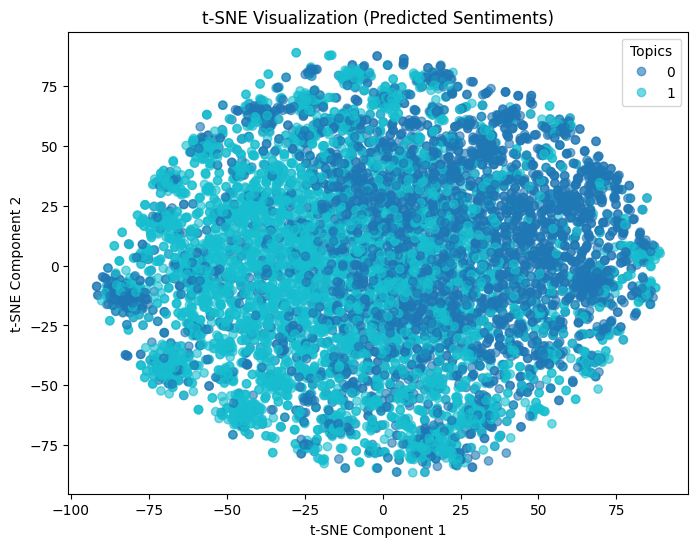

In [5]:
try:
  import shap
except:
  !pip install shap
  import shap

import spacy
import shap
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap.plots

from bs4 import BeautifulSoup
from collections import Counter
from shap import TreeExplainer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Carregando o modelo de lematização do scipy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Função para retirar as tags HTML dos documentos
def strip_html(text):
  return BeautifulSoup(text, 'html.parser').get_text()

# Função para aplicar a lemmatização
def lemmatize_text(text):
  doc = nlp(text)
  return " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

# Função para retornar as palavras de cada tópico gerado pelo LDA
def get_topic_words(lda_model, feature_names, n_top_words=10):
  topic_words = []
  for topic in lda_model.components_:
    top_indices = topic.argsort()[-n_top_words:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    topic_words.append(top_words)
  return topic_words

# Função para pegar o tópico que melhor representa cada documento e retornar uma
# contagem que mostra em quantos documentos cada tópico está presente
def count_documents(lda_matrix):
  dominant_topic = lda_matrix.argmax(axis=1)
  topic_counts = Counter(dominant_topic)
  return topic_counts

# Função para imprimir as palavras mais importantes e a contagem de documentos de cada tópico
def print_lda_topics(lda_model, lda_matrix, feature_names, n_top_words=10):
  topics = get_topic_words(lda_model, feature_names, n_top_words)
  counts = count_documents(lda_matrix)
  for topic_idx, (topic, count) in enumerate(zip(topics, list(counts.values()))):
    print(f"Topic {topic_idx}:", end=' ')
    for word_idx, word in enumerate(topic):
      print(f"{word}", end=' ')
    print(f'- docs: {count}')

# Função para rodar vários n_topics e achar o melhor número de tópicos visualmente
# Retorna um dicionário de n_topic: lda_model
def find_best_n_topics(x_vec, feature_names, n_topics_list, n_top_words=10):
  lda_models = {}
  for n_topics in n_topics_list:
    lda_tmp = LatentDirichletAllocation(
      n_components=n_topics,
      doc_topic_prior=0.1,
      topic_word_prior=0.01,
      random_state=42,
      n_jobs=-1
    )
    lda_matrix = lda_tmp.fit_transform(x_vec)
    print(f'\nTopics: {n_topics}')
    print_lda_topics(lda_tmp, lda_matrix, feature_names)
    lda_models[n_topics] = lda_tmp
  return lda_models

# Carregando o dataset
df = pd.read_csv('https://raw.githubusercontent.com/flaviorv/pb_ai_ml/refs/heads/main/datasets/IMDB%20Dataset.csv')

df.dropna(inplace=True)

# Separando features e target
x = df['review']
y = df['sentiment']

# Dividindo entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, stratify=y, test_size=0.2)

# Retirando as tags HTML e aplicando a lematização para o calcular o melhor hiperparâmetro do número de tópicos
x_train_lemmatized = x_train.apply(strip_html).apply(lemmatize_text)
x_test_lemmatized = x_test.apply(strip_html).apply(lemmatize_text)

# Questão 1 - Criação das features: Computar o Term Frequency-Inverse Document Frequency (TF-IDF)
# para representar a importância das palavras em um conjunto de documentos.

# Stop words customizadas de acordo com o contexto (palavras como film e movie são muito genéricas para o nosso contexto, não trazem informação relevante)
custom_stop_words = ['film', 'movie', 'good', 'bad', 'just', 'people', 'guy', 'life', 'like', 'great', 'really', 'story', 'time', 'watch', 'make', 'think', 'character'] + list(ENGLISH_STOP_WORDS)
# Aplicando o TF-IDF para criar tokens com seus respectivos pesos por documentos
min_df, max_df = 0.05, 0.60
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df=min_df, max_df=max_df)
x_vec = vectorizer.fit_transform(x_train_lemmatized)
feature_names = vectorizer.get_feature_names_out()

# Questão 2 - Modelagem de Tópicos com LDA: Aplicar o algoritmo LDA para identificar tópicos prevalentes nos dados.
# A seleção do número de tópicos será baseada em métricas de coerência para garantir a relevância e a distinção entre
# os tópicos identificados.

# O LDA irá aleatoriamente atribuir tópicos para cada token do TFIDF, após isso ele irá comparar cada token com os tokens do próprio
# documento e com todos os tokens, podendo reatribuir um novo tópico para o token em questão se ver que ele se encaixa melhor em outro contexto.
# Ele faz as comparações iterativamente até que não haja mais correções a fazer e os tópicos estejam coerentes. Ele retorna uma matriz de
# documentos por tópicos, onde os valores são as probabilidades do documento pertencer aos tópicos. Isso ajuda a reduzir a dimensionalidade e
# pode trazer significado para usarmos em um aprendizado supervisionado

# Até com 15 n_topic, os tópicos parecem ter alguma coesão. Nele, tópicos 0 e 1 parecem ter insights positivos e negativos respectivamente. O tópico 2
# parece estar ligado a filmes de terror, o 3 sobre escola, o 5 sobre o gênero ação, o 7 sobre família, o 8 a séries de tv e livros, o 9 tem haver com
# a produção do filme, pois possui palavras como dinheiro, orçamento, efeito especial. O 13 parece estar ligado à música e curta-metragens e o 14, comédia.

# Além da avaliação visual, serão testados todos os números de n_topics no grid para ver qual se sairá melhor

n_topics = [2, 3, 5, 10, 15]
lda_models = find_best_n_topics(x_vec, feature_names, n_topics)

# Questão 3 - Classificação de Textos: Desenvolver modelos de classificação para categorizar os textos com base
# nos tópicos identificados. Você pode escolher qualquer modelo aprendido ao longo do curso e deve escolher o
# melhor modelo usando as técnicas aprendidas, como busca de hiperparâmetros e validação cruzada

# Como o modelo leva um grande tempo de processamento, foi usado o Randomized Search para que limitemos o número de iterações.
# Foi escolhido o Random Forest por ser um modelo caixa preta, como o objetivo é a análise desse tipo de modelo

# Hiperparâmetros
grid_params = {
  'lda__n_components': n_topics,
  'classifier__n_estimators': [100, 300, 500],
  'classifier__max_depth': [3, 5, 10, 15, 20],
  'classifier__min_samples_split': [2, 5, 10],
  'classifier__min_samples_leaf': [2, 5, 10]
}

# Sequência de etapas
pipeline = Pipeline([
  ('tfidf', TfidfVectorizer(stop_words=custom_stop_words, min_df=min_df, max_df=max_df)),
  ('lda', LatentDirichletAllocation(n_components=n_topics, random_state=42)),
  ('scaler', StandardScaler()),
  ('classifier', RandomForestClassifier(random_state=42))
])

# Treinamento com Grid Search e validação cruzada para a escolha do melhor modelo
grid = RandomizedSearchCV(pipeline, grid_params, cv=5, n_iter=20, scoring='f1_macro', n_jobs=-1)
grid.fit(x_train_lemmatized, y_train)
y_pred = grid.predict(x_test_lemmatized)

# Questão 4 - Avaliação de Desempenho: O desempenho dos modelos de classificação será avaliado utilizando métricas como precisão, recall, F1-score e AUC-ROC.

# O modelo conseguiu ter um desempenho médio. Possui 72% de acurácia. Seu recall foi o ponto fraco, 33% dos reviews positivos são classificados como reviews
# negatios.

# A curva ROC, mostra a taxa de Falsos Positivos x Verdadeiros Positivos
# Se mudaros o threshold para ter uma recall maior, a precisão cai. Dependendo do que o cliente deseja, o threshold pode ser alterado

# Recall, precisão, f1-score, acurácia
print('\nBest params:', grid.best_params_)
print(classification_report(y_test, y_pred))

# Prababilidades da classe 'positive' para gerar a curva ROC
y_proba = grid.predict_proba(x_test_lemmatized)[:, 1]

# Alguns métodos como o roc_curve não aceitam strings
sentiment_to_numeric = {'positive': 1, 'negative': 0}
y_test_numeric = y_test.map(sentiment_to_numeric)
y_pred_numeric = np.array([sentiment_to_numeric[s] for s in y_pred])

fpr, tpr, thresholds = roc_curve(y_test_numeric, y_proba)
auc = roc_auc_score(y_test_numeric, y_proba)

# Plotando a curva ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positives (FPR)")
plt.ylabel("True Positives (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Questão 5 - Visualização com t-SNE: Aplicar a técnica de t-SNE nos dados textuais vetorizados para reduzir a dimensionalidade e visualizar
# os agrupamentos de documentos de maneira intuitiva, facilitando a identificação de padrões e outliers.

# O T-SNE é útil para visualização gráfica, diminuindo a dimensionalidade. Ele faz isso preservando as distâncias locais.
# O T-SNE calcula a probabilidade de um ponto ser vizinho de outro, quanto mais próximo, maior essa probabilidade e ele tende
# a preservar essa distância local, mantendo-os próximos no novo espaço que ele cria de baixa dimensionalidade.

# Instanciando o T-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10, max_iter=1000, init='random')

# Utilizando o TF-IDF do grid, que deu fit nos dados dos folds de treino
vectorizer = grid.best_estimator_.named_steps['tfidf']
x_test_vec = vectorizer.transform(x_test_lemmatized)
# Reduzindo a dimensionalidade
x_test_2d = tsne.fit_transform(x_test_vec)

# Plotando o gráfico com o target real
plt.figure(figsize=(8,6))
scatter = plt.scatter(x_test_2d[:,0], x_test_2d[:,1], c=y_test_numeric, cmap='tab10', alpha=0.6)
plt.title("t-SNE Visualization (True Sentiments)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(*scatter.legend_elements(), title="Topics")
plt.show()

# Plotando o gráfico com as previsões do modelo
plt.figure(figsize=(8,6))
scatter = plt.scatter(x_test_2d[:,0], x_test_2d[:,1], c=y_pred_numeric, cmap='tab10', alpha=0.6)
plt.title("t-SNE Visualization (Predicted Sentiments)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(*scatter.legend_elements(), title="Topics")
plt.show()

# Os plots do T-SNE não mostraram uma boa separação entre as classes. Pode indicar dificuldade na classificação

# Questão 6 - Interpretação de Modelos com LIME, SHAP e Force-Plot: Utilizar SHAP para explicar as previsões individuais, identificando a contribuição de cada feature
# para a decisão do modelo. O force-plot será usado para visualizar essas contribuições de maneira agregada, oferecendo insights sobre a lógica de decisão do modelo.

# O SHAP calcula quanto cada feature contribuiu para a previsão de determinada amostra. Ele é otimizado para testar combinações sem e com cada feature, mas não faz isso
# com força bruta, pois poderia ser inviável testar todas as combinações em muitos casos. Por isso, ele utiliza método de amostragem.

# É necessário passar o modelo para que o SHAP entenda-o
explainer = shap.TreeExplainer(grid.best_estimator_['classifier'])
lda_model = grid.best_estimator_.named_steps['lda']

# Preprocessamento
x_test_vec = vectorizer.transform(x_test_lemmatized)
x_test_lda = lda_model.transform(x_test_vec)

# Escolhendo a primeira amostra do conjunto de teste para explicar
sample = x_test_lda[0:1]

# Calculando os valores de Shapley
shap_values = explainer.shap_values(sample)

# Inicializando o javascript para o plot
shap.initjs()

# Gerando o Force Plot para a classe 'positive'
shap.force_plot(
    explainer.expected_value[1],
    shap_values[0, :, 1],
    sample,
    feature_names=[f'Topic {i}' for i in range(lda_model.n_components)]
)

# 7 - Análise dos resultados: Enumere as conclusões que podem ser tomadas a partir dos resultados obtidos.

# O force plot nos mostra as features que mais contribuiram para a previsão. O valor previsto para a primeira amostra foi 0,
# principalmente pelo Topico 0 que teve um valor shap de 0.83, bem maior que o das outras. Conhecidentemente,
# o Tópico 0 é dominante em muito mais amostras que os demais, o que pode sugerir um enviesamento na criação dos tópicos.
# Não apareceram features no plot que contribuiram significantemente para a classe 1 na primeira amostra